# Quantum Neural Networks

In the quantum computing world, it is possible to use machine learning models such as quantum neural networks (QNN), which are a subclass of variational quantum algorithms. We have discussed the notion of feature maps that can also find applications in QNN architectures with the objective being to take advantage of quantum principles such as superposition, entanglement, and interference to increase accuracy, increase the speed of training, and process the model faster. The debate between classical and quantum methods is still open even though some papers have demonstrated a theoretical advantage of the future systems. In Qiskit Machine Learning, there is an interface for all available neural networks. It is called NeuralNetwork and it exposes a forward and a backward pass, taking the data samples and trainable weights as input. Qiskit Machine Learning provides learning algorithms such as NeuralNetworkClassifier and NeuralNetworkRegressor to train neural networks. NeuralNetworkClassifier and NeuralNetworkRegressor take a QNN as input for classification or regression. There are multiple implementations of QNNs, such as Variational Quantum Classifier, classification with an EstimatorQNN or SamplerQNN. 

In [1]:
# Loading your IBM Quantum account: https://quantum-computing.ibm.com
# It requires us to sign with an IBMQ account.
#from qiskit import IBMQ
#IBMQ.save_account('YOUR API')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# sklearn imports
#from sklearn import preprocessing
#from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import train_test_split
#from sklearn import metrics
#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import classification_report

#from qiskit import Aer, QuantumCircuit
#from qiskit.opflow import Z, I, StateFn
#from qiskit.utils import QuantumInstance, algorithm_globals
#from qiskit.circuit import Parameter
#from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
#from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

#from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
#from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
#from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

#from typing import Union

#from qiskit_machine_learning.exceptions import QiskitMachineLearningError

#from IPython.display import clear_output

#algorithm_globals.random_seed = 42


configrc.store_credentials:WARNING:2023-01-15 19:04:49,286: Credentials already present. Set overwrite=True to overwrite.


## Classification with EstimatorQNN

Let’s start with a binary classification using EstimatorQNN within a NeuralNetworkClassifier. In the example below, we will import a .csv file with the dataset we want to classify (neuron morphologies to be classified as interneurons or principal neurons) and preprocess the data as usual: 
	Drop rows having at least one missing value
	Encode the labels to be {−1, +1}
	Divide the data, with y the variable to predict (target) and X the features
	Split the data into training (X_train, y_train) and test (30%)
	Normalize the data
	Perform dimension reduction with PCA (with two principal components)

We then create a quantum instance and build our QNN, create the neural network classifier, fit the classifier to our data, and give the score and prediction using our testing dataset. 
In addition, we create a callback function that will be called for each iteration of the optimizer. It needs two parameters, which are the current weights and the value of the objective function at those weights. 
The EstimatorQNN will return one-dimensional output in [−1,+1] from two classes that we assigned as {−1,+1}.


### Preparing the data

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import dataset
data = '../data/datasets/neurons_binary.csv'
neuron = pd.read_csv(data, delimiter=';')

# Drop row having at least 1 missing value
neuron = neuron.dropna()

# We select some data from the dataset to compute faster
df = neuron.head(22).copy() # Principal neurons
df = pd.concat([df, neuron.iloc[17034:17054]]) # Interneurons

# Creating an instance of Labelencoder
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
# Assigning numerical value and storing it
df[["Target"]] = df[["Target"]].apply(enc.fit_transform)

# Divide the data, y the variable to predict (Target) and X the features
X = df[df.columns[1:]].to_numpy() # We remove labels and convert pandas DataFrame into numpy array
y = df['Target'].replace(0, -1).to_numpy() # We replace our labels by 1 and -1 and convert pandas DataFrame into numpy array

# Splitting the data : training and test (30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
Normalize = preprocessing.Normalizer()
# Transform data
X_train = Normalize.fit_transform(X_train)
X_test = Normalize.fit_transform(X_test)

# Dimension Reduction with PCA (with two principal components)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# transform data
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)


### Create a QNN on Quantum

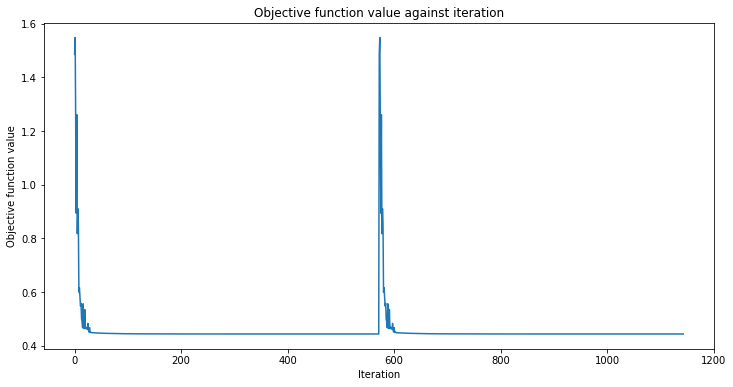

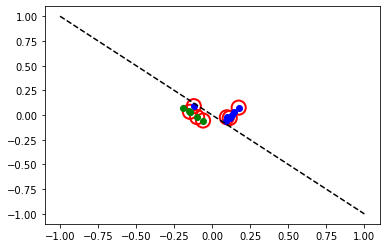

In [18]:
# Variable definition
feature_dimension = 2 # Number of qubits
quantum_backend = None # We use local simulator
reps = 2
# Create quantum instance
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')
# What additional backends we have available.
#for backend in provider.backends():
#    print(backend)

if quantum_backend is not None:
    # Import QiskitRuntimeService and Sampler
    from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
    # Define service
    service = QiskitRuntimeService(channel = 'ibm_quantum', token = ibm_account, instance = 'ibm-q/open/main')
    # Get backend
    backend = service.backend(quantum_backend) # Use a simulator or hardware from the cloud
    # Define Estimator
    # Run Quasi-Probability calculation
    # optimization_level=3 adds dynamical decoupling
    # resilience_level=1 adds readout error mitigation
    from qiskit_ibm_runtime import Options
    options = Options()
    options.resilience_level = 1
    options.execution.shots = 1024
    options.optimization_level = 3
    estimator = Estimator(session=backend, options = options)
else:
    from qiskit.primitives import Estimator
    estimator = Estimator()

# construct feature map
from qiskit.circuit.library import ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension)
# construct ansatz
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(feature_dimension, reps=reps)

# construct quantum circuit
from qiskit import QuantumCircuit
qc = QuantumCircuit(feature_dimension)
qc.append(feature_map, range(feature_dimension))
qc.append(ansatz, range(feature_dimension))
qc.decompose().draw()
        
# Build QNN
from qiskit_machine_learning.neural_networks import EstimatorQNN
estimator_qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator = estimator
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []

# callback function that draws a live plot when the .fit() method is called
from IPython.display import clear_output
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
# Create the neural network classifier
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA
estimator_classifier = NeuralNetworkClassifier(neural_network=estimator_qnn, optimizer=COBYLA(), callback=callback_graph)

estimator_classifier = NeuralNetworkClassifier(estimator_qnn, optimizer=COBYLA(), callback=callback_graph)

# fit classifier to data
estimator_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X_train, y_train)

# Predict data points from X_test
y_predict = estimator_classifier.predict(X_test)



#plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X_test, y_test)

# Predict data points from X_test dataset
y_predict = estimator_classifier.predict(X_test)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_train, y_train, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()



In [19]:
print(estimator_classifier.score(X_test, y_test))

0.7692307692307693


In [21]:
# Print predicted values and real values of the X_test dataset
print("\n")
print("Print predicted data coming from X_test as new input data")
print(y_predict)
print("\n")
print("Print real values\n")
print(y_test)
print("\n")

# Print accuracy metrics of the model
from sklearn import metrics
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
results = [metrics.balanced_accuracy_score(y_true=y_test, y_pred=y_predict), metrics.accuracy_score(y_test, y_predict),metrics.precision_score(y_test, y_predict, average='micro'),metrics.recall_score(y_test, y_predict, average='micro'),metrics.f1_score(y_test, y_predict, average='micro')]
metrics_dataframe = pd.DataFrame(results, index=["Balanced Accuracy", "Accuracy", "Precision", "Recall", "F1 Score"], columns=['estimator_classifier'])
print('Classification Report: \n')
print(classification_report(y_test,y_predict))
        
metrics_dataframe





Print predicted data coming from X_test as new input data
[[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


Print real values

[-1  1  1 -1  1 -1  1 -1 -1  1 -1  1  1]


Classification Report: 

              precision    recall  f1-score   support

          -1       0.71      0.83      0.77         6
           1       0.83      0.71      0.77         7

    accuracy                           0.77        13
   macro avg       0.77      0.77      0.77        13
weighted avg       0.78      0.77      0.77        13



,estimator_classifier
Balanced Accuracy,0.773810
Accuracy,0.769231
Precision,0.769231
Recall,0.769231
F1 Score,0.769231


## Classification with a SamplerQNN

Here we will use a SamplerQNN to classify our neurons within a NeuralNetworkClassifier. 

### Preparing the data

In [24]:
# Import dataset
data = '../data/datasets/neurons_binary.csv'
neuron = pd.read_csv(data, delimiter=';')

# Drop row having at least 1 missing value
neuron = neuron.dropna()

# We select some data from the dataset to compute faster
df = neuron.head(22).copy() # Principal neurons
df = pd.concat([df, neuron.iloc[17033:17053]]) # Interneurons

# Creating an instance of Labelencoder
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
# Assigning numerical value and storing it
df[["Target"]] = df[["Target"]].apply(enc.fit_transform)

# Divide the data, y the variable to predict (Target) and X the features
X = df[df.columns[1:]].to_numpy() # We remove labels and convert pandas DataFrame into numpy array
y = df['Target'].to_numpy()

# Splitting the data : training and test (30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
from sklearn.preprocessing import Normalizer
Normalize = preprocessing.Normalizer()
# Transform data
X_train = Normalize.fit_transform(X_train)
X_test = Normalize.fit_transform(X_test)

# Dimension Reduction with PCA (with two principal components)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# transform data
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)


### Create a QNN on Quantum

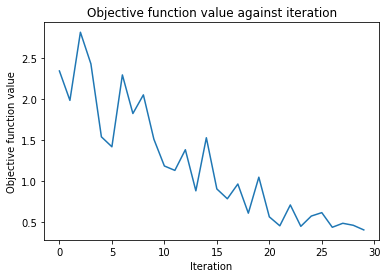

In [30]:
# Variable definition
#number_inputs = 2  # Number of quibits
number_classes = 2 # Number of classes
# Variable definition
feature_dimension = 2 # Number of qubits
quantum_backend = None # We use local simulator
reps = 2

# Create quantum instance
# Create quantum instance
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')

# Define a quantum instance
#backend = provider.get_backend('simulator_statevector')
#quantum_instance = QuantumInstance(backend, shots=1024)

if quantum_backend is not None:
    # Import QiskitRuntimeService and Sampler
    from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
    # Define service
    service = QiskitRuntimeService(channel = 'ibm_quantum', token = ibm_account, instance = 'ibm-q/open/main')
    # Get backend
    backend = service.backend(quantum_backend) # Use a simulator or hardware from the cloud
    # Define Sampler
    # Run Quasi-Probability calculation
    # optimization_level=3 adds dynamical decoupling
    # resilience_level=1 adds readout error mitigation
    from qiskit_ibm_runtime import Options
    options = Options()
    options.resilience_level = 1
    options.execution.shots = 1024
    options.optimization_level = 3
    sampler = Sampler(session=backend, options = options)
else:
    from qiskit.primitives import Sampler
    sampler = Sampler()

# construct feature map
from qiskit.circuit.library import ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension)

# construct ansatz
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(feature_dimension, reps=reps)
    
# construct quantum circuit
from qiskit import QuantumCircuit
qc = QuantumCircuit(feature_dimension)
qc.append(feature_map, range(feature_dimension))
qc.append(ansatz, range(feature_dimension))
qc.decompose().draw()
            
# Build QNN
from qiskit_machine_learning.neural_networks import SamplerQNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    output_shape=number_classes,
    sampler=sampler
)

# construct classifier
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA
sampler_classifier = NeuralNetworkClassifier(
neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
    
# fit classifier to data
sampler_classifier.fit(X_train, y_train)

# score classifier
sampler_classifier.score(X_train, y_train)

# evaluate data points
y_predict = sampler_classifier.predict(X_test)
    
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# return to default figsize
#plt.rcParams["figure.figsize"] = (6, 4)


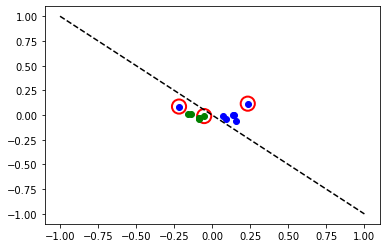

In [28]:
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()



In [29]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Print predicted values and real values of the X_test dataset
print("\n")
print("Print predicted data coming from X_test as new input data")
print(y_predict)
print("\n")
print("Print real values\n")
print(y_test)
print("\n")

# Print accuracy metrics of the model
from sklearn import metrics
results = [metrics.balanced_accuracy_score(y_true=y_test, y_pred=y_predict), metrics.accuracy_score(y_test, y_predict),metrics.precision_score(y_test, y_predict, average='micro'),metrics.recall_score(y_test, y_predict, average='micro'),metrics.f1_score(y_test, y_predict, average='micro')]
metrics_dataframe = pd.DataFrame(results, index=["Balanced Accuracy", "Accuracy", "Precision", "Recall", "F1 Score"], columns=['sampler_classifier'])
print('Classification Report: \n')
print(classification_report(y_test,y_predict))
        
metrics_dataframe




Print predicted data coming from X_test as new input data
[0 1 0 0 1 1 0 0 0 1 0 1 1]


Print real values

[0 1 1 0 1 0 1 0 0 1 0 1 1]


Classification Report: 

              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.83      0.71      0.77         7

    accuracy                           0.77        13
   macro avg       0.77      0.77      0.77        13
weighted avg       0.78      0.77      0.77        13



,sampler_classifier
Balanced Accuracy,0.773810
Accuracy,0.769231
Precision,0.769231
Recall,0.769231
F1 Score,0.769231


## Classification with Variational Quantum Classifier (VQC)

A special variant of the NeuralNetworkClassifier with a SamplerQNN is the Variational Quantum Classifier (VQC). The cross-entropy loss function is applied by default expecting labels in one-hot encoded. 

### Prepare Data

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import dataset
data = '../data/datasets/neurons_binary.csv'
#data = '../data/datasets/neurons.csv'
neuron = pd.read_csv(data, delimiter=';')

# Drop row having at least 1 missing value
neuron = neuron.dropna()

# We select some data from the dataset to compute faster
df = neuron.head(22).copy() # Principal neurons
df = pd.concat([df, neuron.iloc[17033:17053]]) # Interneurons

# Creating an instance of Labelencoder
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
# Assigning numerical value and storing it
df[["Target"]] = df[["Target"]].apply(enc.fit_transform)

# Divide the data, y the variable to predict (Target) and X the features
X = df[df.columns[1:]].to_numpy() # We remove labels and convert pandas DataFrame into numpy array
y = df['Target'].to_numpy()

# Splitting the data : training and test (30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data
from sklearn.preprocessing import Normalizer
Normalize = preprocessing.Normalizer()
# Transform data
X_train = Normalize.fit_transform(X_train)
X_test = Normalize.fit_transform(X_test)

# Dimension Reduction with PCA (with two principal components)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# transform data
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

# One-hot encode target column
# A column will be created for each output category.
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



### Create VQC

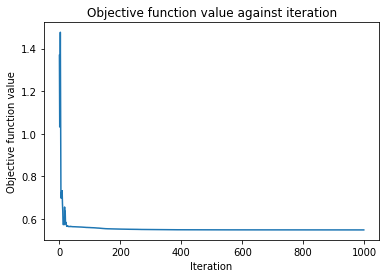

In [33]:
# Variable definition
number_classes = 2 # Number of classes
# Variable definition
feature_dimension = 2 # Number of qubits
quantum_backend = None # We use local simulator
reps = 2

# Create quantum instance
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q')

# Define a quantum instance
#backend = provider.get_backend('simulator_statevector')
#quantum_instance = QuantumInstance(backend, shots=1024)

# Create feature map, ansatz, and optimizer
#feature_map = ZZFeatureMap(number_inputs)
#ansatz = RealAmplitudes(number_inputs, reps=1)

# Create VQC
#vqc = VQC(
#    feature_map=feature_map,
#    ansatz=ansatz,
#    loss="cross_entropy",
#    optimizer=COBYLA(),
#    quantum_instance=quantum_instance,
#    callback=callback_graph,
#)

# create empty array for callback to store evaluations of the objective function
#objective_func_vals = []
#plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
#vqc.fit(X_train, y_train)

# return to default figsize
#plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
#vqc.score(X_test, y_test)
    
# Create feature map, ansatz, and optimizer
from qiskit.circuit.library import ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension)
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(feature_dimension, reps=reps)
    
if quantum_backend is not None:
    # Import QiskitRuntimeService and Sampler
    from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
    # Define service
    service = QiskitRuntimeService(channel = 'ibm_quantum', token = ibm_account, instance = 'ibm-q-internal/deployed/default')
    # Get backend
    backend = service.backend(quantum_backend) # Use a simulator or hardware from the cloud
    # Define Sampler: With our training and testing datasets ready, we set up the FidelityQuantumKernel class to calculate a kernel matrix using the ZZFeatureMap. We use the reference implementation of the Sampler primitive and the ComputeUncompute fidelity that computes overlaps between states. These are the default values and if you don't pass a Sampler or Fidelity instance, the same objects will be created automatically for you.
    # Run Quasi-Probability calculation
    # optimization_level=3 adds dynamical decoupling
    # resilience_level=1 adds readout error mitigation
    from qiskit_ibm_runtime import Options
    options = Options()
    options.resilience_level = 1
    options.execution.shots = 1024
    options.optimization_level = 3
    sampler = Sampler(session=backend, options = options)
else:
    from qiskit.primitives import Sampler
    sampler = Sampler()

from qiskit_machine_learning.algorithms.classifiers import VQC
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(),
    sampler= sampler,
    callback=callback_graph,
)
    
# Create empty array for callback to store evaluations of the objective function
objective_func_vals = []
    
# fit classifier to data and calculate elpased time
import time
start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

# score classifier
vqc.score(X_train, y_train)

# Predict data points from X_test
y_predict = vqc.predict(X_test)



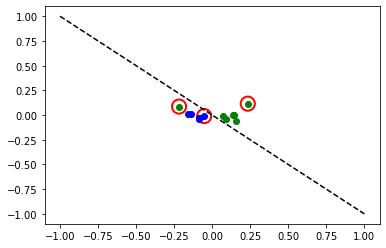

In [34]:
# evaluate data points
#y_predict = vqc.predict(X_test)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [36]:
print(vqc.score(X_train, y_train))

0.9655172413793104
